### Download required libraries

In [1]:
!pip install ultralytics roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 601.5 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.6/793.6 kB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 27.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.82
    Uninstalling opencv-python-headless-4.10.0.82:
      Successfully uninstalled opencv-python-headless-4.10.0.82
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the 

In [2]:
import os
from roboflow import Roboflow
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import urllib.request

In [3]:
# Do this so Kaggle doesn't ask for WanDB API key
os.environ['WANDB_MODE'] = 'dryrun'

### Download dataset from Roboflow

In [4]:
VERSION_NUMBER = 11 # Send help
rf = Roboflow(api_key="axkMMYWOTatnBEO0soPa") # Use your Roboflow API key here
project = rf.workspace("quan-le-0ctih").project("web-element-detection-nah")
version = project.version(VERSION_NUMBER)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.45, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Web-Element-Detection-Nah-11 in yolov8:: 100%|██████████| 2420/2420 [00:00<00:00, 7063.70it/s]


In [5]:
# Update data.yaml
import yaml

# Define the correct paths to your dataset directories
train_images_path = f'/kaggle/working/Web-Element-Detection-Nah-{VERSION_NUMBER}/train/images'
val_images_path = f'/kaggle/working/Web-Element-Detection-Nah-{VERSION_NUMBER}/valid/images'
test_images_path = f'/kaggle/working/Web-Element-Detection-Nah-{VERSION_NUMBER}/test/images'

# Path to the data.yaml file
data_yaml_path = f'/kaggle/working/Web-Element-Detection-Nah-{VERSION_NUMBER}/data.yaml'

# Load the existing data.yaml file
with open(data_yaml_path, 'r') as file:
    data_yaml = yaml.safe_load(file)

# Update the paths in the data.yaml file
data_yaml['train'] = train_images_path
data_yaml['val'] = val_images_path
data_yaml['test'] = test_images_path

# Save the updated data.yaml file
with open(data_yaml_path, 'w') as file:
    yaml.safe_dump(data_yaml, file)

print(f'Updated data.yaml file saved at {data_yaml_path}')

Updated data.yaml file saved at /kaggle/working/Web-Element-Detection-Nah-11/data.yaml


### Use YOLOv10 small as base model for fine-tuning

In [6]:
model = YOLO('yolov10s.pt')
model.info()

100%|██████████| 15.9M/15.9M [00:00<00:00, 138MB/s]


YOLOv10s summary: 402 layers, 8128272 parameters, 8128256 gradients, 25.1 GFLOPs


(402, 8128272, 8128256, 25.109759999999998)

In [7]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [8]:
!nvidia-smi

Thu Jun 27 08:57:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Train model using train set, and validate during the process

In [9]:
# More augmentation
augmentation_params = {
    'hsv_h': 0.1,  # Hue shift
    'hsv_s': 0.3,    # Saturation shift
    'hsv_v': 0.3,    # Value shift
    'flipud': 0.5,   # Vertical flip (probability)
    'fliplr': 0.5,   # Horizontal flip (probability)
    'scale': 0.4,    # Zoom factor
    'translate': 0.2
}

Remember to run all cell, or at least the cell after this cell so it DOESNT STOP IN THE MIDDLE OF THE TRAINING PROCESS
Just make sure u don't idle over 40 minutes (run some cell after this cell or just add some code/comment whatever)

In [10]:
results = model.train(data=f"Web-Element-Detection-Nah-{VERSION_NUMBER}/data.yaml",
                      epochs=500,
                      imgsz=640,
                      #freeze=10, # Freeze back-bone layers (https://github.com/ultralytics/ultralytics/issues/189)
                      patience=50,
                      batch=32,
                      #cos_lr=True,
                      val=True,
                      verbose=True,
                      plots=True,
                      device=[0, 1],
                      **augmentation_params) # Use 2 T4 GPU from Kaggle (Colab could never)

Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10s.pt, data=Web-Element-Detection-Nah-11/data.yaml, epochs=500, time=None, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False

100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]
2024-06-27 08:57:54,915	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-27 08:57:55,977	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1     36096  ultralytics.nn.modules.block.SCDown          [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1    137728  ultralytics

wandb: Tracking run with wandb version 0.17.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Overriding model.yaml nc=80 with nc=5
Transferred 607/619 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 72.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/Web-Element-Detection-Nah-11/train/labels... 804 images, 0 backgrounds, 0 corrupt: 100%|██████████| 804/804 [00:00<00:00, 1028.09it/s]


train: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/train/images/9to5mac_com_png.rf.ca1c9e6248ac6731d54387fbdd758396.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/train/images/aarp_org_png.rf.6f6eecabcde2d493f07552ece7222105.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/train/images/aka_ms_png.rf.35013a0cb0ea4bca6c20ba7800d0aa5c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/train/images/aljazeera_net_png.rf.611b06aa58f78c18f58ef4577dd4501b.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/train/images/alternativeto_net_png.rf.5272e824423052eaf909c29b686b4442.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/train/images/amazon_co_uk_png.rf.506caa27e1e553e623def23a81897f6e.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/Web-E

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/Web-Element-Detection-Nah-11/valid/labels... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<00:00, 1100.11it/s]


val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/valid/images/academic_oup_com_png.rf.4cf45092ee96d65effaac1be923aef28.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/valid/images/aliexpress_com_png.rf.094493f4764da1f578d779448f548b78.jpg: 4 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/valid/images/amazon_ca_png.rf.32e49f21d60c20b2bab770aeb9befba9.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/valid/images/amazon_it_png.rf.d1c671129b19e76c17dcfce39321553a.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/valid/images/bandsintown_com_png.rf.62d59717b343f6ca035cf9492ffd8269.jpg: 4 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/valid/images/banggood_com_png.rf.6bc0b48e309b70602f6cdded2907625e.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element

      1/500      6.36G      3.611      7.081      2.798         81        640: 100%|██████████| 26/26 [00:28<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


                   all        250       9288      0.364      0.234      0.128     0.0746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      6.96G      2.821      3.794       2.37         87        640: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


                   all        250       9288      0.319      0.427      0.285      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      6.56G      2.727      3.419      2.313        112        640: 100%|██████████| 26/26 [00:10<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.364      0.376      0.288      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      7.87G      2.751      3.278      2.282         46        640: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.417      0.427      0.386      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500      6.57G      2.676      3.211      2.252        134        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.438      0.449      0.398      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500      7.69G      2.669      3.161      2.262        113        640: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.434      0.444      0.395      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500      6.92G      2.649      3.109      2.235        118        640: 100%|██████████| 26/26 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288       0.41       0.45      0.391      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500      6.49G      2.615      3.021      2.218        119        640: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.435      0.464      0.417      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500      7.64G      2.609          3      2.235         65        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


                   all        250       9288      0.428       0.48      0.393      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      6.89G       2.61      2.997      2.228         44        640: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.452      0.454      0.436      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500      6.91G      2.545      2.897        2.2         73        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288       0.48      0.464      0.449        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500      7.69G      2.502      2.863      2.185        130        640: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.495      0.484       0.46      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500      6.73G      2.503      2.836      2.182        103        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.464      0.477      0.453      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500       6.9G      2.451      2.765      2.155         98        640: 100%|██████████| 26/26 [00:11<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.463      0.455      0.441      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500      6.98G        2.5      2.891      2.202         69        640: 100%|██████████| 26/26 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.466      0.467      0.453      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500      6.56G      2.471      2.834      2.169        148        640: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.499      0.495       0.47      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500      6.48G      2.401      2.749      2.136         74        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


                   all        250       9288      0.483      0.489      0.474      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/500      6.34G      2.482      2.764      2.146         62        640: 100%|██████████| 26/26 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.517      0.464      0.469      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/500      7.04G      2.414      2.692       2.12         26        640: 100%|██████████| 26/26 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


                   all        250       9288      0.542      0.467      0.486      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/500      6.87G      2.397      2.741      2.122        102        640: 100%|██████████| 26/26 [00:11<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.529      0.518       0.51      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500      7.02G      2.405      2.665       2.14        105        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.516      0.512      0.505      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500         7G      2.422      2.689       2.15         91        640: 100%|██████████| 26/26 [00:11<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.501      0.511      0.495      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/500      6.37G      2.365      2.659      2.129         77        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.506      0.504      0.487      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/500      6.34G      2.356       2.64       2.12        150        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.505      0.515      0.501      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/500      6.75G      2.364      2.688      2.121         31        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.518      0.502      0.514      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500      7.74G      2.386      2.624      2.133         56        640: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.524      0.515      0.515      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/500      6.56G       2.32      2.596      2.095        239        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.531      0.499      0.511      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/500      6.74G      2.351      2.613      2.112         85        640: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288       0.54      0.536      0.533       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500      7.14G      2.344       2.61      2.107         47        640: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.552      0.505      0.513      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/500      6.62G      2.293      2.592      2.097         78        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.515      0.516      0.514       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500      6.68G      2.336      2.561      2.106         67        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.517      0.527      0.526      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500       6.9G      2.273      2.522      2.079         81        640: 100%|██████████| 26/26 [00:10<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.514      0.531      0.517      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/500      7.26G      2.299       2.52      2.084         69        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.521      0.505      0.515      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/500      6.54G      2.296      2.546      2.079         90        640: 100%|██████████| 26/26 [00:10<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.528      0.549      0.527      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/500      6.75G      2.307      2.439      2.071         47        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.522      0.519      0.522      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/500      6.52G       2.28      2.471      2.074         52        640: 100%|██████████| 26/26 [00:11<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.517      0.504      0.514      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/500      7.23G       2.35      2.525      2.086        112        640: 100%|██████████| 26/26 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288       0.54      0.553      0.539       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/500      7.25G      2.251      2.452      2.051         43        640: 100%|██████████| 26/26 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.527      0.548      0.542      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500      6.47G      2.302      2.438      2.079         55        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.562      0.463      0.496      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/500      6.11G      2.232      2.395      2.062         99        640: 100%|██████████| 26/26 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.594       0.51      0.538      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/500      6.87G      2.295      2.415       2.07        114        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.542      0.555      0.547      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/500      6.75G      2.224      2.388      2.059         86        640: 100%|██████████| 26/26 [00:11<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.537      0.558      0.561      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/500       6.9G      2.229       2.33      2.052         95        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.553      0.516      0.533      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/500      6.75G      2.227      2.398       2.06        134        640: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.553      0.521      0.532      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/500      6.91G      2.252      2.474      2.082         67        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.528      0.535       0.53      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/500       6.6G      2.223      2.444      2.057        122        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.552      0.541      0.556      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/500      6.48G      2.237      2.353      2.049        123        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.548      0.549      0.552       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/500      7.11G      2.193      2.333       2.03        106        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.617      0.514      0.549      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/500      6.85G      2.198      2.367      2.072         72        640: 100%|██████████| 26/26 [00:10<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.573      0.533      0.549      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/500      6.75G       2.28      2.363      2.066         68        640: 100%|██████████| 26/26 [00:11<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288       0.58      0.537       0.56      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/500      6.77G      2.183      2.321      2.038         69        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.527      0.559      0.556      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/500      6.52G      2.184      2.308       2.04        118        640: 100%|██████████| 26/26 [00:11<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.558      0.521      0.551       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/500      6.37G      2.183      2.305      2.029         78        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.557      0.546      0.554       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/500       6.8G      2.165      2.314      2.031         53        640: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288       0.56      0.525      0.547      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/500      7.91G      2.203      2.301      2.026        156        640: 100%|██████████| 26/26 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.577      0.556      0.575      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500      7.32G       2.17      2.286      2.022         44        640: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.539      0.531      0.542       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/500      7.02G      2.187      2.247       2.02         96        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


                   all        250       9288      0.547       0.55      0.551      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/500      6.71G      2.201      2.321      2.035         60        640: 100%|██████████| 26/26 [00:10<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


                   all        250       9288      0.545      0.541      0.553      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/500      7.25G      2.162      2.213      2.021        153        640: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.569      0.542      0.567      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/500      7.42G      2.138      2.237      2.013         50        640: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.593       0.52      0.556      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/500      6.34G      2.103      2.192      2.004        138        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.584      0.559      0.574      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500      6.69G      2.123       2.17      2.009        138        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


                   all        250       9288      0.592      0.551      0.573      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500      6.79G      2.143      2.215      2.012         94        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.543      0.537      0.552       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500      6.84G      2.163      2.223      2.004         71        640: 100%|██████████| 26/26 [00:10<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


                   all        250       9288      0.571      0.571      0.565      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/500       7.2G      2.162      2.238      2.016        161        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.583      0.532      0.561      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500      6.37G      2.163      2.199      2.012        117        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


                   all        250       9288      0.537      0.569      0.554      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500      6.23G      2.097      2.151      2.005        121        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.551      0.548      0.542      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/500      6.28G      2.072      2.146      1.991         94        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


                   all        250       9288      0.569      0.549      0.561      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/500      6.31G      2.103      2.171      2.026        101        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.574      0.553      0.572       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/500      6.44G      2.125      2.138      1.998        230        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


                   all        250       9288      0.579      0.555      0.564      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/500      6.86G      2.164       2.18      2.014        201        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


                   all        250       9288      0.566      0.567      0.573      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500      6.68G       2.17      2.157       2.03         88        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


                   all        250       9288      0.581      0.552      0.568      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/500      6.22G      2.135      2.123      1.999        180        640: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.602      0.544      0.575      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/500      6.55G      2.095      2.111      2.003         64        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


                   all        250       9288      0.576      0.567       0.57      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500      7.76G      2.075      2.038      1.986         68        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.566      0.556      0.562        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/500      6.63G      2.115      2.121      2.001        116        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


                   all        250       9288       0.56      0.548      0.559        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/500      6.95G      2.098       2.16      2.012         50        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.585      0.546       0.56      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/500      6.92G      2.051      2.063      1.982        117        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


                   all        250       9288       0.57      0.571      0.571      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500      7.65G      2.032      2.038      1.974         50        640: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.581      0.558      0.574      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500      6.93G      2.073      2.096      1.996        145        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


                   all        250       9288      0.569      0.555       0.57        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/500      7.47G      2.131      2.105      1.992        148        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.583      0.559      0.571      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/500      6.66G      2.053      2.055      1.993         95        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


                   all        250       9288      0.562      0.537      0.544      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/500      6.61G      2.021      2.068      1.986         72        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.554      0.555      0.555       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/500      6.58G      2.033      2.039      1.989         24        640: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


                   all        250       9288      0.609      0.533      0.561      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/500      6.25G      2.043      2.049      2.004         82        640: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.551      0.578      0.573      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/500      6.78G      1.989      2.012      1.966        100        640: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


                   all        250       9288      0.577      0.555      0.575      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/500      6.19G      2.045      2.087      2.007        100        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.569       0.56      0.572      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/500      7.43G      2.005      1.958      1.968        105        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.602      0.564      0.583      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/500      6.72G      2.018      1.976      1.964        205        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.591      0.542       0.58      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/500      7.61G      2.056      1.993      1.973         96        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.583       0.56      0.582      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/500         7G      2.049       1.98      1.973        132        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.574      0.552       0.57       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/500      6.74G      2.014      1.964      1.966         77        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


                   all        250       9288      0.597      0.557      0.578      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/500      6.96G       2.07      2.041       1.97         79        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.583      0.564      0.582      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/500      6.63G      2.028      2.029      1.994         64        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


                   all        250       9288      0.617       0.53      0.573       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/500      7.09G      2.016      1.997      1.955        134        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.576      0.559      0.567      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/500      7.18G      2.004      1.935      1.962         93        640: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.578      0.579      0.583       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/500       7.1G      1.988      1.907      1.955        111        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.581      0.566      0.575      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/500      6.77G      2.001       1.91      1.946         52        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


                   all        250       9288       0.57       0.57      0.565      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500      7.23G      1.952      1.882      1.946         64        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


                   all        250       9288      0.544      0.572      0.568      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/500      6.91G      1.981      1.909      1.948         66        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.578      0.554      0.563      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/500      6.92G      1.958      1.937       1.96         38        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288       0.54      0.542      0.552      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/500      7.03G      2.033      1.953      1.976        132        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.578      0.556      0.574      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/500      7.21G      2.023      1.961      1.959         88        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.595      0.552      0.579      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/500      7.23G      2.058      1.918      1.962        119        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.561      0.559      0.564      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/500      6.49G      2.004      1.913       1.96         85        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.583       0.58      0.576      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/500      7.29G      1.989      1.915      1.952        104        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.597      0.538      0.565      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/500      6.83G      2.002      1.896      1.954         47        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.618       0.54      0.575      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/500      6.26G      1.948      1.867      1.948         67        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.588      0.555       0.58      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500      6.97G      1.989      1.843      1.933        131        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.605      0.558       0.58      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/500      6.69G      1.947       1.89      1.953         51        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.566      0.568       0.58      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/500      6.33G      1.965      1.855      1.933        169        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.609       0.56      0.581      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/500      6.25G       1.97      1.827      1.942         76        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.578      0.566      0.569      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/500      6.92G      1.941      1.832      1.929        128        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.628      0.554      0.587      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/500      6.61G      1.957      1.843       1.95        111        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.597       0.53      0.571      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/500      7.91G      1.907      1.809      1.931        111        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288       0.59      0.547      0.569      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/500      7.36G      1.978       1.85      1.958        139        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.584       0.56      0.568      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/500      7.14G      1.978      1.871      1.972         57        640: 100%|██████████| 26/26 [00:11<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.602      0.569      0.579      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/500      6.98G      1.925      1.776      1.921         99        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


                   all        250       9288      0.595      0.551      0.575      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/500      6.45G      1.958      1.795      1.943         99        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.598      0.556       0.57      0.408


  0%|          | 0/26 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/500       6.5G      1.909      1.779      1.913         71        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.624      0.552      0.582      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/500      7.37G      1.979      1.795       1.92         66        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.591      0.553      0.574      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/500      7.51G      1.963      1.747      1.921         89        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.583      0.576      0.578      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/500      6.87G      1.946      1.792       1.95         76        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.603      0.588      0.593      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/500       6.3G        1.9      1.741      1.913        115        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.599      0.565      0.584      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/500      6.39G      1.899      1.733      1.912         62        640: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.575      0.563       0.58      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/500      6.49G      1.927      1.725      1.915        155        640: 100%|██████████| 26/26 [00:10<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


                   all        250       9288      0.595      0.565       0.58      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/500      7.38G      1.865      1.708       1.91        217        640: 100%|██████████| 26/26 [00:10<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


                   all        250       9288      0.574      0.581      0.581      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/500      7.14G      1.909      1.746      1.917        140        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.582      0.581      0.579      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/500      6.52G      1.893       1.76      1.939        151        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.573      0.567       0.57      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/500      6.32G      1.925      1.758       1.93         86        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.587      0.571      0.585      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/500      6.98G      1.884      1.667      1.912         79        640: 100%|██████████| 26/26 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288       0.62      0.559      0.585      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/500      7.82G      1.891      1.689      1.903        115        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.588       0.57      0.575      0.405


  0%|          | 0/26 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/500      6.81G      1.923      1.719      1.921        108        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.603      0.567       0.58      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/500       6.6G       1.87      1.692      1.913         66        640: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.576      0.568      0.577      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/500      6.77G      1.913      1.724      1.932         45        640: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.587      0.594      0.585       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/500      6.83G      1.897      1.673      1.925         65        640: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


                   all        250       9288      0.591      0.549       0.57      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/500      6.57G      1.841      1.683      1.918         64        640: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.596      0.565      0.577      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/500       6.4G      1.844      1.655      1.906         41        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.592      0.545      0.554      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/500      6.44G      1.874      1.723      1.916         46        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.617      0.557      0.584      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/500      6.64G      1.864       1.67      1.906        149        640: 100%|██████████| 26/26 [00:10<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.597      0.575      0.584      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/500      6.72G      1.892      1.662      1.919         84        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.592      0.571      0.585      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/500      7.65G      1.851      1.652      1.902         82        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288       0.59      0.574      0.581      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/500      6.62G       1.85      1.653      1.892         63        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.584      0.572      0.579      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/500      7.29G      1.859      1.663      1.903         92        640: 100%|██████████| 26/26 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288       0.61      0.562      0.587       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/500      7.27G      1.848      1.676      1.919        109        640: 100%|██████████| 26/26 [00:10<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.603      0.553      0.573      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/500      6.64G      1.816      1.647      1.911         88        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.606      0.565      0.579      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/500      6.45G      1.848      1.639      1.902         52        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.604      0.569       0.59      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/500      6.55G      1.835      1.629      1.912        136        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


                   all        250       9288      0.608      0.554      0.576      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/500      6.75G      1.881      1.684      1.906        109        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.614      0.547      0.578      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/500      6.72G      1.831      1.595      1.888        128        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


                   all        250       9288      0.617      0.559      0.577      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/500      6.63G      1.855      1.621      1.926         64        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.598      0.559      0.572      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/500      7.25G      1.855      1.604      1.898        116        640: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


                   all        250       9288      0.609       0.57       0.59      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/500      7.62G      1.865      1.634      1.894        107        640: 100%|██████████| 26/26 [00:10<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.583      0.588      0.589      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/500      6.86G       1.83      1.575      1.893        117        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


                   all        250       9288      0.608      0.576      0.582      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/500      7.04G      1.851       1.56      1.885        130        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.613      0.574       0.59      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/500      6.89G      1.839      1.606      1.888        128        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


                   all        250       9288      0.605      0.559      0.582      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/500      7.41G      1.817      1.565      1.894        126        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.609       0.56      0.589      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/500      6.15G      1.827      1.587      1.894         41        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


                   all        250       9288      0.607      0.564      0.574      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/500      6.52G      1.876       1.57      1.893         55        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.622       0.57      0.589      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/500      7.91G      1.829      1.517      1.879         43        640: 100%|██████████| 26/26 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


                   all        250       9288      0.614      0.584      0.589      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/500      6.99G      1.815      1.525      1.891         70        640: 100%|██████████| 26/26 [00:10<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


                   all        250       9288      0.606      0.573      0.589      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/500      6.81G      1.825      1.528      1.889        113        640: 100%|██████████| 26/26 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


                   all        250       9288      0.604       0.58      0.594      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/500      7.35G      1.817      1.547      1.898        117        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.597      0.567       0.58      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/500      6.82G      1.767      1.526      1.904         60        640: 100%|██████████| 26/26 [00:10<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


                   all        250       9288      0.593      0.571      0.581      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/500      7.67G      1.859      1.547      1.883         69        640: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.613      0.567      0.586      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/500      6.64G      1.774      1.506      1.876         40        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.611      0.578      0.578      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/500      6.49G      1.779      1.493      1.865         96        640: 100%|██████████| 26/26 [00:10<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.615      0.561      0.582      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/500      7.13G      1.774      1.474       1.87        188        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


                   all        250       9288      0.645      0.548      0.591      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/500      6.73G      1.773       1.54      1.885         71        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


                   all        250       9288      0.614      0.548      0.583      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/500       7.3G      1.791      1.491      1.884         78        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


                   all        250       9288      0.609      0.567      0.588       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/500      6.72G      1.783      1.494      1.886         33        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.593       0.58      0.588      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/500      6.47G      1.741      1.464      1.876        156        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288        0.6      0.579      0.582      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/500      7.19G      1.765      1.484      1.867        113        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


                   all        250       9288      0.622      0.557      0.577      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/500      6.51G      1.785      1.493      1.879         85        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


                   all        250       9288      0.577      0.576      0.572      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/500      6.41G       1.78      1.531      1.883        115        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


                   all        250       9288      0.612      0.572      0.592      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/500      6.51G      1.757      1.484      1.868         57        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


                   all        250       9288      0.609      0.568      0.587      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/500      6.18G      1.761      1.478      1.876         68        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.618      0.583      0.588      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/500      6.75G      1.754      1.446      1.855         72        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.615      0.584      0.591      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/500      7.12G       1.75      1.447      1.858         58        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.617      0.581      0.597      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/500      7.34G      1.795      1.476      1.879        121        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


                   all        250       9288      0.618      0.572       0.58      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/500      6.74G      1.754      1.457      1.879         78        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.632      0.559      0.583      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/500      7.69G      1.772      1.436       1.86         94        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


                   all        250       9288      0.617      0.557      0.581       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/500      6.18G      1.752      1.436      1.854         53        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.607      0.563      0.578      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/500      6.44G      1.754      1.454      1.876         69        640: 100%|██████████| 26/26 [00:10<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.604      0.584       0.58      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/500      6.08G      1.728      1.434      1.865         95        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.607      0.585      0.594      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/500      6.49G      1.739      1.442      1.863         69        640: 100%|██████████| 26/26 [00:10<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.616      0.567      0.584      0.421


  0%|          | 0/26 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/500      6.38G      1.721      1.397      1.857         77        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.604      0.569       0.58      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/500      6.55G      1.744      1.415      1.869        147        640: 100%|██████████| 26/26 [00:10<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.608      0.583      0.578      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/500       6.6G      1.702      1.391      1.866        105        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.627      0.555      0.579      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/500      6.95G       1.77      1.438      1.877         59        640: 100%|██████████| 26/26 [00:10<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.588      0.594      0.579      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/500      6.88G      1.741      1.413      1.869        173        640: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.615      0.563      0.577      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/500      6.41G      1.736       1.45      1.881         63        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


                   all        250       9288      0.599      0.577      0.581      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/500      6.39G       1.76      1.438      1.855        214        640: 100%|██████████| 26/26 [00:10<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.624      0.571       0.58       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/500      6.88G      1.778      1.448      1.875        129        640: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288       0.61      0.564      0.579      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/500      6.53G      1.705      1.415      1.856         51        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.594      0.572      0.574      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/500      7.01G      1.727      1.407      1.859         41        640: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.599      0.576      0.581      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/500      6.73G       1.73      1.387      1.856        135        640: 100%|██████████| 26/26 [00:11<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.601      0.581      0.581      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/500      7.04G      1.723      1.374      1.849        170        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.626       0.58      0.587       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/500      7.03G      1.697      1.388      1.843         87        640: 100%|██████████| 26/26 [00:10<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.633      0.564      0.582      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/500      6.68G      1.731      1.393      1.855        100        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.609      0.582      0.586      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/500      7.31G      1.722      1.393      1.842         58        640: 100%|██████████| 26/26 [00:11<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288       0.62      0.567       0.59      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/500       7.1G      1.733       1.36      1.861         38        640: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


                   all        250       9288      0.618      0.579      0.583      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/500      7.24G      1.735      1.375      1.838        198        640: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.618      0.583      0.594      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/500      6.43G      1.717      1.369      1.859        146        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.625      0.569      0.589      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/500      6.65G      1.693       1.38      1.855        106        640: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.621      0.571      0.586      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/500      6.94G      1.698      1.366      1.849         60        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.614      0.564      0.577      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/500      6.85G      1.698      1.342      1.854        143        640: 100%|██████████| 26/26 [00:11<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.604      0.579      0.581      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/500      6.33G      1.693      1.359      1.854        107        640: 100%|██████████| 26/26 [00:10<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.599      0.589      0.584      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/500      7.63G      1.712      1.346      1.837         73        640: 100%|██████████| 26/26 [00:11<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.631       0.57      0.592      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/500      6.39G      1.659      1.341      1.847         98        640: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


                   all        250       9288      0.617      0.602      0.599      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/500      7.87G      1.728      1.348      1.848         96        640: 100%|██████████| 26/26 [00:11<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.628      0.568      0.587      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/500      6.79G      1.665      1.302      1.826         98        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


                   all        250       9288      0.624      0.572      0.583      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/500      6.54G      1.729      1.361       1.85        134        640: 100%|██████████| 26/26 [00:11<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.606      0.575      0.579      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/500      6.65G      1.674      1.321      1.851         70        640: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.596      0.588      0.586      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/500      6.46G      1.683      1.319      1.834        102        640: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


                   all        250       9288       0.61      0.583      0.587      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/500      6.71G      1.688      1.348      1.851         36        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


                   all        250       9288      0.637      0.569      0.586      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/500      6.86G      1.651      1.283      1.833         87        640: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


                   all        250       9288      0.636      0.559      0.588      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/500      7.03G      1.686      1.299      1.836         95        640: 100%|██████████| 26/26 [00:11<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


                   all        250       9288      0.627      0.576      0.592      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/500      6.09G      1.656      1.319      1.841        168        640: 100%|██████████| 26/26 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.639      0.567      0.588      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/500      6.89G      1.687      1.375       1.84         41        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


                   all        250       9288      0.635      0.562      0.591      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/500      7.11G      1.672      1.331       1.84         62        640: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


                   all        250       9288      0.602      0.595      0.594       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/500      6.58G       1.68      1.345       1.85         37        640: 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288       0.62      0.561      0.585      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/500      6.17G      1.621      1.276      1.823        117        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.606      0.568      0.585      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/500       7.2G      1.638       1.27      1.843         98        640: 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.645      0.546      0.581      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/500      8.11G      1.677      1.271      1.826         96        640: 100%|██████████| 26/26 [00:10<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


                   all        250       9288       0.63      0.553      0.585      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/500      7.13G      1.641      1.264       1.82        111        640: 100%|██████████| 26/26 [00:10<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


                   all        250       9288      0.604      0.579      0.575      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/500      6.86G      1.699      1.334       1.84        286        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


                   all        250       9288      0.622      0.558      0.578      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/500      6.77G      1.667      1.319      1.843         63        640: 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


                   all        250       9288      0.626      0.562      0.583      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/500      6.72G      1.648       1.29      1.836        130        640: 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


                   all        250       9288      0.613      0.575      0.584      0.423
EarlyStopping: Training stopped early as no improvement observed in last 50 epochs. Best results observed at epoch 179, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

229 epochs completed in 1.011 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 16.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 16.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
YOLOv10s summary (fused): 293 layers, 8038830 parameters, 0 gradients, 24.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:21<00:00,  2.67s/it]


                   all        250       9288       0.62      0.577      0.597      0.431
                button        239       2872      0.641      0.524      0.582      0.393
                 field        114        165      0.699      0.806      0.813      0.685
                 image        244       1670       0.63      0.522      0.591      0.429
                  link        194       1170      0.505      0.496      0.455      0.302
                  text        250       3411      0.623      0.536      0.544      0.346
Speed: 0.2ms preprocess, 6.2ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁███▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂
wandb:                  lr/pg1 ▁███▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂
wandb:                  lr/pg2 ▁███▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂
wandb:        metrics/mAP50(B) ▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇▇██████▇██▇█████████
wandb:     metrics/mAP50-95(B) ▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇▇██████▇██▇█████████
wandb:    metrics/precision(B) ▁▄▅▅▅▅▅▆█▆▆▇▇▆▆▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██████
wandb:       metrics/recall(B) ▁▂▃▂▅▅▄▆▄��▆▇▆▆▅▆▅▆▅▇▆▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇█▇▆▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb:          train/cls_loss █▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▇▆▅▅▄▄▄▃▃▄▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁
wandb:            val/box_loss █▆▄▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▂▂▂▁▁▁

### Result Visualization

In [34]:
def showImageWithSrc(src):
    img = mpimg.imread(src)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.show()
    
def showImage(img):
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.show()

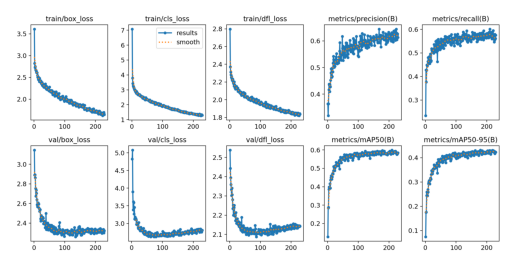

In [12]:
showImageWithSrc('runs/detect/train/results.png')

### Test the model against validation and test set

In [13]:
validation_results = model.val(data=f"Web-Element-Detection-Nah-{VERSION_NUMBER}/data.yaml", 
                               imgsz=640, 
                               batch=32, 
                               conf=0.4, 
                               iou=0.5, 
                               device=[0, 1], 
                               split="val")

Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
YOLOv10s summary (fused): 293 layers, 8038830 parameters, 0 gradients, 24.5 GFLOPs


val: Scanning /kaggle/working/Web-Element-Detection-Nah-11/valid/labels.cache... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/valid/images/academic_oup_com_png.rf.4cf45092ee96d65effaac1be923aef28.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/valid/images/aliexpress_com_png.rf.094493f4764da1f578d779448f548b78.jpg: 4 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/valid/images/amazon_ca_png.rf.32e49f21d60c20b2bab770aeb9befba9.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/valid/images/amazon_it_png.rf.d1c671129b19e76c17dcfce39321553a.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/valid/images/bandsintown_com_png.rf.62d59717b343f6ca035cf9492ffd8269.jpg: 4 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/valid/images/banggood_com_png.rf.6bc0b48e309b70602f6cdded2907625e.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:20<00:00,  2.57s/it]


                   all        250       9288       0.66      0.541      0.602      0.473
                button        239       2872      0.683      0.478      0.585      0.449
                 field        114        165      0.739      0.788      0.808      0.707
                 image        244       1670      0.681       0.49        0.6      0.488
                  link        194       1170      0.543      0.462      0.463      0.331
                  text        250       3411      0.654       0.49      0.553      0.389
Speed: 0.3ms preprocess, 11.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train2


In [14]:
test_results = model.val(data=f"Web-Element-Detection-Nah-{VERSION_NUMBER}/data.yaml", 
                               imgsz=640, 
                               batch=32, 
                               conf=0.4, 
                               iou=0.5, 
                               device=[0, 1], 
                               split="test")

Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)


val: Scanning /kaggle/working/Web-Element-Detection-Nah-11/test/labels... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<00:00, 1142.07it/s]

val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/test/images/amazon_es_png.rf.94614bb942ebc05513fb0c8209740784.jpg: 4 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/test/images/computer_org_png.rf.0a220b54cff0cb5ff2c31249bae433b4.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/test/images/coursera_org_png.rf.6848d885b4d037c4e6050af73403774d.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/test/images/elle_com_png.rf.d39f09da41e3408d4678bcc63219af02.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/test/images/entrepreneur_com_png.rf.feea1ab2cd17e6f218146675557b151a.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detection-Nah-11/test/images/it_linkedin_com_png.rf.cb53e5a932611ac711f7a4648e062b88.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Web-Element-Detectio


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


                   all        150       5868       0.68      0.548       0.62      0.489
                button        145       1713      0.662        0.5       0.59       0.48
                 field         76        136      0.786      0.728      0.799      0.685
                 image        149       1045      0.656      0.494       0.59      0.479
                  link        108        810      0.616      0.537      0.557        0.4
                  text        150       2164      0.678      0.482      0.565      0.398
Speed: 0.3ms preprocess, 12.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train3


### Inference test

In [15]:
best_model = YOLO('runs/detect/train/weights/best.pt')
best_model.info()

YOLOv10s summary: 402 layers, 8070222 parameters, 0 gradients, 24.8 GFLOPs


(402, 8070222, 0, 24.7872)

In [16]:
# Import image URL or image path here for CPU inference
CLASSES = { 0: 'button', 1: 'field', 2: 'image', 3: 'link', 4: 'text'}
TEST_IMAGE_URL = 'https://backendless.com/wp-content/uploads/2020/07/Flutter-Code-Generation-1200x681.png'
prediction = best_model.predict(TEST_IMAGE_URL, 
                                imgsz=640,
                                conf=0.4,
                                iou=0.5,
                                device="cpu",
                                classes=[0, 1, 2, 3, 4]) # Edit classes as comment above to filter if needed (bth chac ko can, nay de test thoi)
prediction[0].save(filename="result.jpg")

100%|██████████| 65.6k/65.6k [00:00<00:00, 3.25MB/s]


image 1/1 /kaggle/working/Flutter-Code-Generation-1200x681.png: 384x640 15 buttons, 1 field, 7 images, 10 texts, 228.3ms
Speed: 2.3ms preprocess, 228.3ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)


'result.jpg'

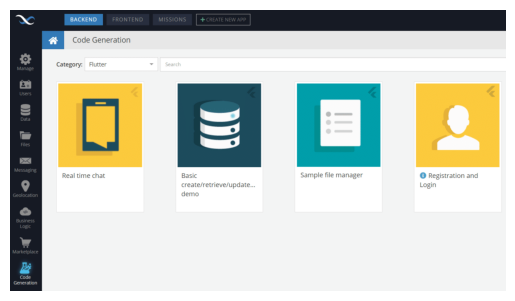

In [17]:
showImageWithSrc("Flutter-Code-Generation-1200x681.png")

In [58]:
def plot_with_custom_boxes(image, results, colors):
    for i, det in enumerate(results[0].boxes):
        box = det.xyxy[0] # xyxy format (top-left x, top-left y, bottom-right x, bottom-right y)
        label = int(det.cls[0])
        conf = round((det.conf[0].item()), 2)
        color = colors[label % len(colors)]  # Choose color based on label
        # Draw bounding box
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
        # Put label text
        cv2.putText(image, f'{conf} {CLASSES[label]}', (int(box[0]), int(box[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    return image

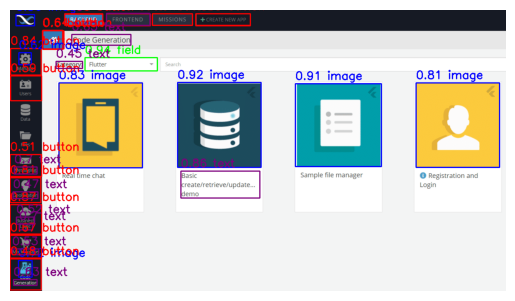

In [59]:
custom_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (125, 125, 0), (125, 0, 125)]
req = urllib.request.urlopen(TEST_IMAGE_URL)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
image = cv2.imdecode(arr, -1) # 'Load it as it is'
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Since opencv image is read as BGR instead of RGB, needs to reverse it back
output_image = plot_with_custom_boxes(image, prediction, custom_colors)

# Have to use plt to show image cuz kaggle
showImage(output_image)

### Model exports

In [20]:
# Export to different format, for inference testing
best_model.export(format='onnx')
best_model.export(format='openvino')
#best_model.export(format='coreml') # for MacOS and iOS

Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (15.8 MB)

ONNX: starting export with onnx 1.16.1 opset 17...
ONNX: export success ✅ 1.6s, saved as 'runs/detect/train/weights/best.onnx' (27.8 MB)

Export complete (3.6s)
Results saved to /kaggle/working/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.onnx imgsz=640 data=Web-Element-Detection-Nah-11/data.yaml  
Visualize:       https://netron.app
Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (15.8 MB)
requirements: Ultralytics requirement ['openvino>=2024.0.0'] not found, a

'runs/detect/train/weights/best_openvino_model'

In [21]:
# Zip the whole working directory
import shutil
shutil.make_archive("capstone", 'zip', "/kaggle/working/runs")

'/kaggle/working/capstone.zip'

### Benchmarks

In [38]:
onnx_model = YOLO('runs/detect/train/weights/best.onnx')
onnx_prediction = onnx_model.predict(TEST_IMAGE_URL, 
                                     conf=0.4,
                                     iou=0.5,
                                     device="cpu",
                                     classes=[0, 1, 2, 3, 4]) # Edit classes as comment above to filter if needed (bth chac ko can, nay de test thoi)

Loading runs/detect/train/weights/best.onnx for ONNX Runtime inference...

Found https://backendless.com/wp-content/uploads/2020/07/Flutter-Code-Generation-1200x681.png locally at Flutter-Code-Generation-1200x681.png
image 1/1 /kaggle/working/Flutter-Code-Generation-1200x681.png: 640x640 14 buttons, 1 field, 7 images, 9 texts, 168.1ms
Speed: 5.6ms preprocess, 168.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


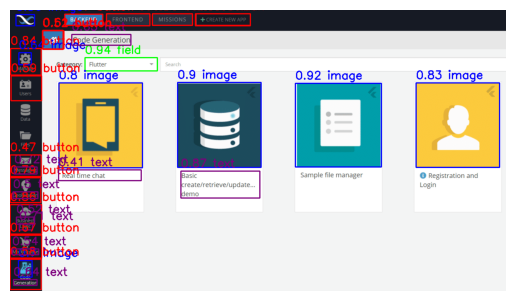

In [62]:
custom_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (125, 125, 0), (125, 0, 125)]
req = urllib.request.urlopen(TEST_IMAGE_URL)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
image = cv2.imdecode(arr, -1) # 'Load it as it is'
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Since opencv image is read as BGR instead of RGB, needs to reverse it back
output_image = plot_with_custom_boxes(image, onnx_prediction, custom_colors)

# Have to use plt to show image cuz kaggle
showImage(output_image)

In [24]:
openvino_model = YOLO('runs/detect/train/weights/best_openvino_model')
openvino_prediction = onnx_model.predict(TEST_IMAGE_URL, 
                                     conf=0.4,
                                     iou=0.5,
                                     device="cpu",
                                     classes=[0, 1, 2, 3, 4]) # Edit classes as comment above to filter if needed (bth chac ko can, nay de test thoi)


Found https://backendless.com/wp-content/uploads/2020/07/Flutter-Code-Generation-1200x681.png locally at Flutter-Code-Generation-1200x681.png
image 1/1 /kaggle/working/Flutter-Code-Generation-1200x681.png: 640x640 14 buttons, 1 field, 7 images, 9 texts, 265.5ms
Speed: 3.6ms preprocess, 265.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


In [25]:
!pip install deepsparse[yolov8]

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.6/612.6 kB 657.9 kB/s eta 0:00:000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 61.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 26.2 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 MB 34.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.5.3
    Uninstalling pydantic-2.5.3:
      Successfully uninstalled pydantic-2.5.3
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.82
    Uninstalling opencv-python-4.10.0.82:
      Succe

In [26]:
!deepsparse.benchmark runs/detect/train/weights/best.onnx --scenario=sync --input_shapes="[1,3,640,640]"

2024-06-27 10:02:31 deepsparse.benchmark.helpers INFO     Thread pinning to cores enabled
DeepSparse, Copyright 2021-present / Neuralmagic, Inc. version: 1.7.1 COMMUNITY | (3904e8ec) (release) (optimized) (system=avx512, binary=avx512)
2024-06-27 10:02:34 deepsparse.benchmark.benchmark_model INFO     deepsparse.engine.Engine:
	onnx_file_path: runs/detect/train/weights/best.onnx
	batch_size: 1
	num_cores: 2
	num_streams: 1
	scheduler: Scheduler.default
	fraction_of_supported_ops: 0.9434
	cpu_avx_type: avx512
	cpu_vnni: False
2024-06-27 10:02:34 deepsparse.utils.onnx INFO     Generating input 'images', type = float32, shape = [1, 3, 640, 640]
2024-06-27 10:02:34 deepsparse.benchmark.benchmark_model INFO     Starting 'singlestream' performance measurements for 10 seconds
Original Model Path: runs/detect/train/weights/best.onnx
Batch Size: 1
Scenario: sync
Throughput (items/sec): 10.2510
Latency Mean (ms/batch): 97.5394
Latency Median (ms/batch): 94.4577
Latency Std (ms/batch): 10.6584
Ite